In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt

2022-11-04 09:29:53.363504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 09:29:53.499837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 09:29:53.499859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-04 09:29:53.537260: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 09:29:54.099288: W tensorflow/stream_executor/platform/de

In [3]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

In [4]:
N_STEPS = 7
LOOKUP_STEPS = [1]
STOCK = 'KAHOT.OL'

date_now = tm.strftime('%Y-%m-%d')
yesterday  = dt.date.today() - dt.timedelta(days=2)
date_3_years_back = (yesterday - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [5]:
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [6]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

[4.26942700e-03 1.01679704e-02 9.88709157e-03 1.12915017e-02
 1.69091663e-02 1.38194511e-02 1.38194511e-02 9.04443907e-03
 9.04443907e-03 9.04443907e-03 1.22745936e-02 1.26959198e-02
 1.35385723e-02 1.12915017e-02 1.12915017e-02 1.94371157e-02
 2.53356511e-02 3.65709802e-02 3.09533237e-02 3.51665701e-02
 3.79753903e-02 4.78063093e-02 4.78063093e-02 5.03342508e-02
 5.02219057e-02 5.53901497e-02 6.32548688e-02 6.04460486e-02
 5.90416224e-02 5.67945598e-02 5.76372123e-02 5.90416224e-02
 4.91826412e-02 5.73563335e-02 5.06151296e-02 4.58401255e-02
 4.63738049e-02 4.78063093e-02 5.20195558e-02 5.90416224e-02
 6.04460486e-02 5.96033961e-02 6.46592950e-02 7.30857879e-02
 6.79175278e-02 7.02769516e-02 6.32548688e-02 7.78607919e-02
 8.15122807e-02 8.14841864e-02 7.88438838e-02 8.29166908e-02
 7.75799131e-02 8.06696282e-02 8.13718413e-02 8.43211009e-02
 8.43211009e-02 8.43211009e-02 9.55564301e-02 1.05668228e-01
 1.03982923e-01 9.27475938e-02 8.99106792e-02 8.75231772e-02
 9.13431836e-02 8.881524

/tmp/ipykernel_10693/1202582793.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style='seaborn-whitegrid')


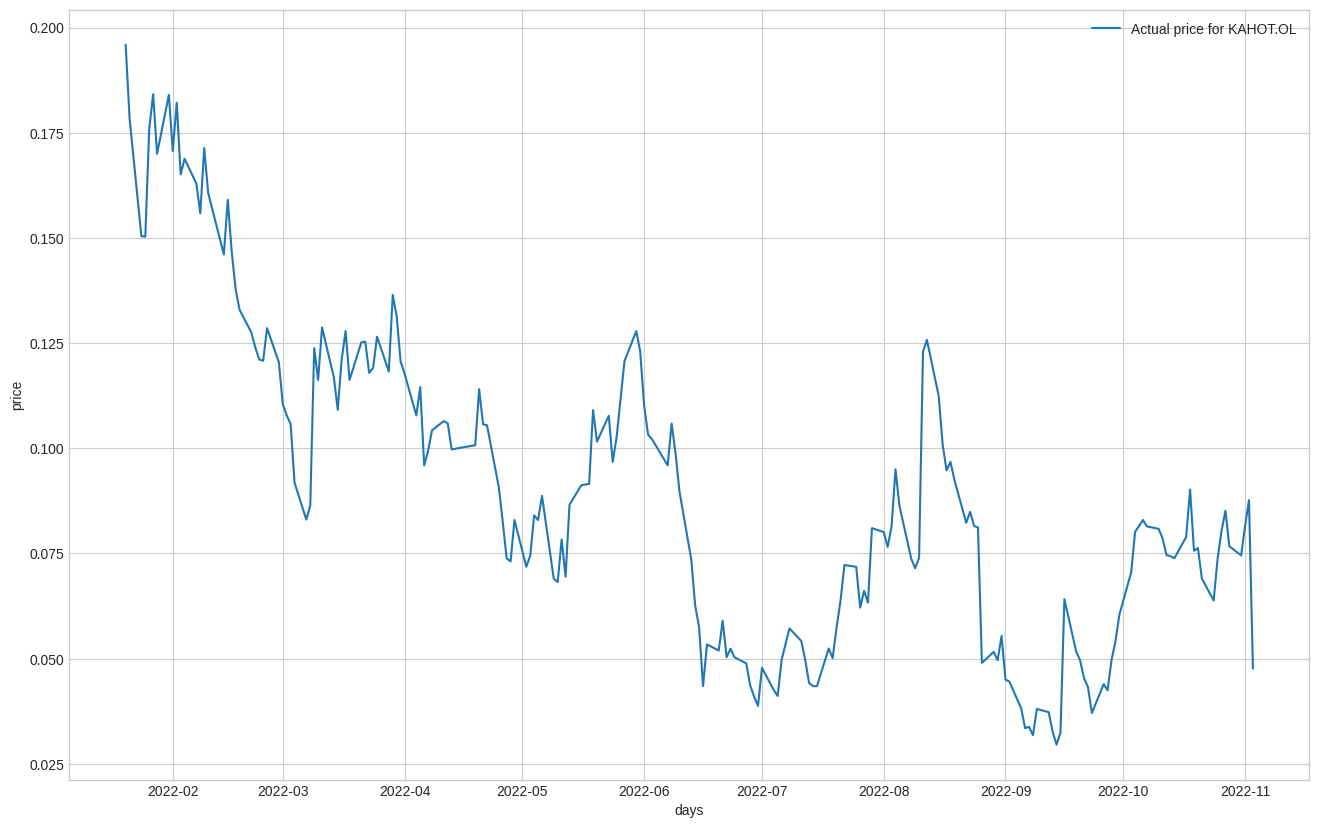

In [23]:
data = init_df['close']
data = np.append(data,0.005)
today = str(tm.strftime('%Y-%m-%d'))
print(data)

plt.style.use(style='seaborn-whitegrid')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
#plt.show()

In [8]:
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [9]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(attention(return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(20))
  model.add(Dense(1))

  # model2 = Sequential()
  # model2.add(Embedding(n_unique_words, 128, input_length=maxlen))
  # model2.add(Bidirectional(LSTM(64, return_sequences=True)))
  # model2.add(attention(return_sequences=True)) # receive 3D and output 3D
  # model2.add(Dropout(0.5))
  # model2.add(Dense(1, activation='sigmoid'))
  # model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # model2.summary()


  BATCH_SIZE = 8
  EPOCHS = 100

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model.summary()

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [10]:
def PrepareData():
  df = init_df.copy()
  df['future'] = df['close']
  last_sequence = np.array(df['close'][-7:])
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [11]:

predictions = []
print("started")
df, last_sequence, x_train, y_train = PrepareData()
x_train = x_train[:, :, :len(['close'])].astype(np.float32)
model = GetTrainedModel(x_train, y_train)
# print(last_sequence)
last_sequence = last_sequence[-N_STEPS:]
# print(last_sequence)
last_sequence = np.expand_dims(last_sequence, axis=0)
prediction = model.predict(last_sequence)
print(f"Prediction{prediction}")
predicted_price = scaler.inverse_transform(prediction)[0][0]
print(predicted_price)

predictions.append(round(float(predicted_price), 2))
print(predictions)

started


/tmp/ipykernel_10693/3779544858.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  last_sequence = np.array(last_sequence).astype(np.float32)
2022-11-04 09:29:56.758057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 09:29:56.758399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 09:29:56.758459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shar

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 60)             14880     
                                                                 
 dropout (Dropout)           (None, 7, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 20)                2420      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 104,201
Trainable params: 104,201
Non-trai

KeyboardInterrupt: 

In [ ]:
scaler.inverse_transform(model.predict(last_sequence))[0][0]

# numbers = []
# for x in range(1):
#     numbers.append(program())
# print(numbers.sum/len(numbers))

1/1 [==============================] - 0s 29ms/step


23.679255